# 机器学习预测CO2排放量

## 导入和安装库

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

## 导入数据

In [2]:
df = pd.read_csv("CO2_Emissions.csv")

## 预处理

In [3]:
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape

(6282, 12)

In [4]:
df.columns = df.columns.str.replace(" (L/100 km)", "")
df.columns = df.columns.str.replace("(L)", "")
df.columns = df.columns.str.replace("(g/km)", "")
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.lower()
df.columns

Index(['make', 'model', 'vehicle_class', 'engine_size', 'cylinders',
       'transmission', 'fuel_type', 'fuel_consumption_city',
       'fuel_consumption_hwy', 'fuel_consumption_comb',
       'fuel_consumption_comb_(mpg)', 'co2_emissions'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6282 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make                         6282 non-null   object 
 1   model                        6282 non-null   object 
 2   vehicle_class                6282 non-null   object 
 3   engine_size                  6282 non-null   float64
 4   cylinders                    6282 non-null   int64  
 5   transmission                 6282 non-null   object 
 6   fuel_type                    6282 non-null   object 
 7   fuel_consumption_city        6282 non-null   float64
 8   fuel_consumption_hwy         6282 non-null   float64
 9   fuel_consumption_comb        6282 non-null   float64
 10  fuel_consumption_comb_(mpg)  6282 non-null   int64  
 11  co2_emissions                6282 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 638.0+ KB


## 标签编码 

数据集中有几个分类列，由于其中一些列中有很多变量，使用标签编码器来更好地训练模型。

In [6]:
columns_to_encode = ['make','model','vehicle_class','transmission','fuel_type']
label_encoders = {}

for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # 保留编码器以供回收

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6282 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make                         6282 non-null   int32  
 1   model                        6282 non-null   int32  
 2   vehicle_class                6282 non-null   int32  
 3   engine_size                  6282 non-null   float64
 4   cylinders                    6282 non-null   int64  
 5   transmission                 6282 non-null   int32  
 6   fuel_type                    6282 non-null   int32  
 7   fuel_consumption_city        6282 non-null   float64
 8   fuel_consumption_hwy         6282 non-null   float64
 9   fuel_consumption_comb        6282 non-null   float64
 10  fuel_consumption_comb_(mpg)  6282 non-null   int64  
 11  co2_emissions                6282 non-null   int64  
dtypes: float64(4), int32(5), int64(3)
memory usage: 515.3 KB


In [8]:
df.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb,fuel_consumption_comb_(mpg),co2_emissions
0,0,1057,0,2.0,4,14,4,9.9,6.7,8.5,33,196
1,0,1057,0,2.4,4,25,4,11.2,7.7,9.6,29,221
2,0,1058,0,1.5,4,22,4,6.0,5.8,5.9,48,136
3,0,1233,11,3.5,6,15,4,12.7,9.1,11.1,25,255
4,0,1499,11,3.5,6,15,4,12.1,8.7,10.6,27,244


In [9]:
y= df['co2_emissions'].values
x= df.drop(columns=['co2_emissions']).values

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.75,random_state=42)

## 缩放

在1和0之间缩放值将加快模型训练过程，因此使用MinMaxScaler()。

In [11]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## 模型构建

In [12]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

## 提前停止

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
148/148 [==============================] - 2s 6ms/step - loss: 48757.4414 - mae: 209.3771 - val_loss: 13746.6553 - val_mae: 108.8095
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 3616.7888 - mae: 44.3948 - val_loss: 13209.0576 - val_mae: 106.8711
Epoch 3/100
148/148 [==============================] - 1s 4ms/step - loss: 1387.5500 - mae: 29.4159 - val_loss: 2933.0566 - val_mae: 44.7804
Epoch 4/100
148/148 [==============================] - 1s 3ms/step - loss: 1202.7573 - mae: 27.5744 - val_loss: 855.8322 - val_mae: 22.8858
Epoch 5/100
148/148 [==============================] - 0s 3ms/step - loss: 1053.9192 - mae: 25.4842 - val_loss: 463.6434 - val_mae: 15.9548
Epoch 6/100
148/148 [==============================] - 1s 4ms/step - loss: 1045.1962 - mae: 25.4668 - val_loss: 145.5837 - val_mae: 8.4182
Epoch 7/100
148/148 [==============================] - 1s 5ms/step - loss: 948.4937 - mae: 24.2699 - val_loss: 112.8552 - val_mae: 7.4897
Epoch 8/100
14

## 模型结果

In [14]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_loss:.2f}")

50/50 [==============================] - 0s 2ms/step - loss: 38.9554 - mae: 4.4688
Test MAE: 4.47
Test MSE: 38.96


In [15]:
y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print(f"R² Skoru: {r2:.4f}")

50/50 [==============================] - 0s 2ms/step
R² Skoru: 0.9893


## 模型结果可视化

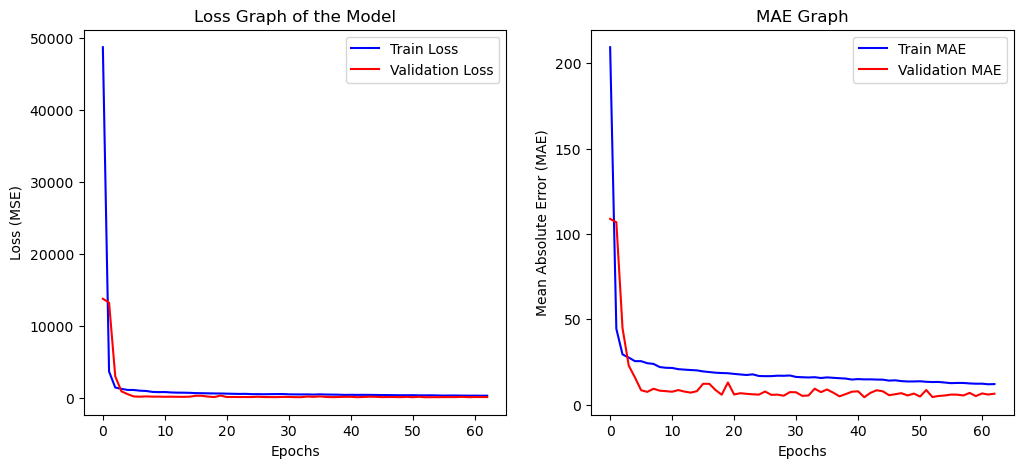

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Graph of the Model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], color='b', label='Train MAE')
plt.plot(history.history['val_mae'], color='r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Graph')
plt.legend()

plt.show()

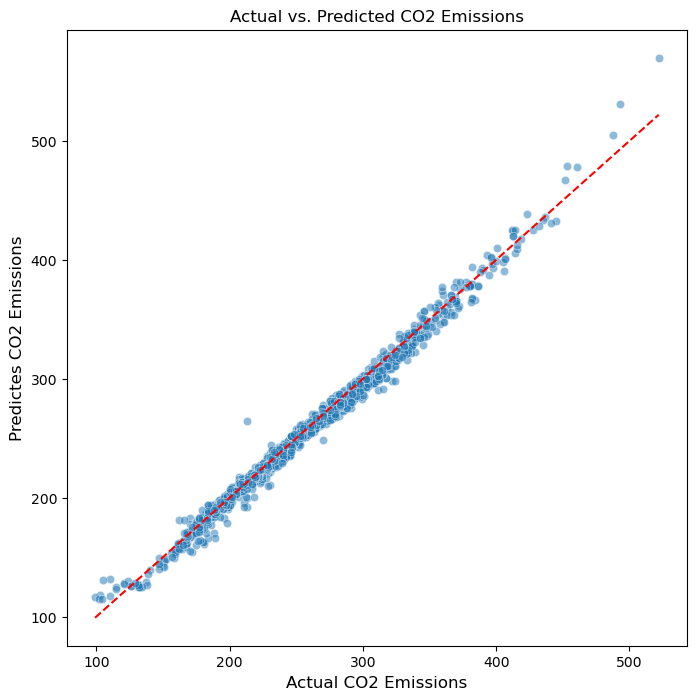

In [17]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual CO2 Emissions", fontsize=12)
plt.ylabel("Predictes CO2 Emissions", fontsize=12)
plt.title("Actual vs. Predicted CO2 Emissions", fontsize=12)
plt.show()

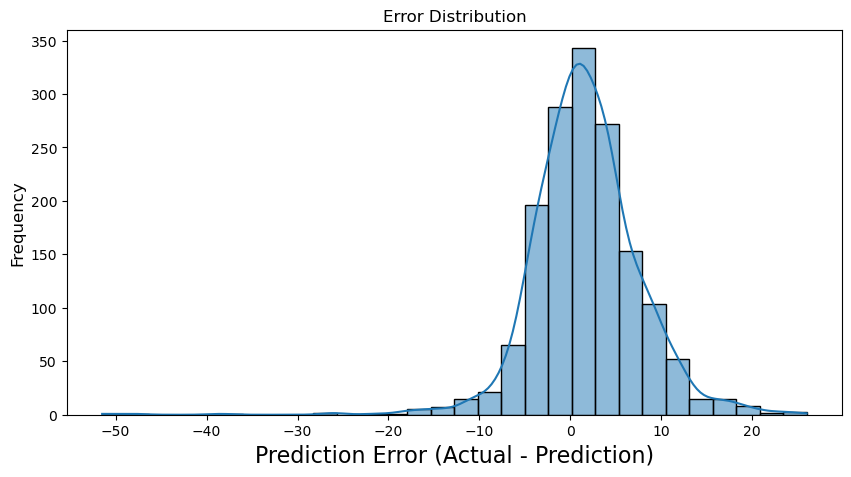

In [18]:
errors = y_test - y_pred.flatten()

plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error (Actual - Prediction)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.title("Error Distribution", fontsize=12)
plt.show()